# 9.ChIP-seq
## 9.6 Peak calling
### 9.6.5 Peak annotation


最後に、ChIP-seq から同定したピーク領域のゲノム上のどこに分布しているのか（TSS, exon, intron, intergenic）を可視化する。

In [2]:
# AnnotationHub ライブラリの読み込み
library(AnnotationHub)

In [3]:
# ヒト遺伝子のアノテーション情報を取得(ダウンロード)
# MEMO: GRCh38.92 -> AH61126 のデータを使用
# MEMO: 読み込みにかなり時間がかかる(5minぐらい)
hub = AnnotationHub()
gtf = hub[['AH61126']]

using temporary cache /var/folders/5l/9jr5d9t912x662bhf5tjh7q40000gn/T//RtmpqcHwQ7/BiocFileCache

snapshotDate(): 2020-10-27

downloading 1 resources

retrieving 1 resource

loading from cache

Importing File into R ..

require(“rtracklayer”)



In [4]:
# chr21 のみを抽出
seqlevels(gtf, pruning.mode='coarse') = '21'

# 染色体名に chr の prefix をつける
seqlevels(gtf, pruning.mode='coarse') = paste0('chr', seqlevels(gtf))

In [6]:
# アノテーションの優先順を作る
# [tss[], exon[], intron[]] の GRange オブジェクトのリストを作る
annotation_list = GRangesList(
  tss    = promoters(subset(gtf, type=='gene'), 1000, 1000),
  exon   = subset(gtf, type=='exon'),
  intron = subset(gtf, type=='gene')
)
annotation_list

GRangesList object of length 3:
$tss
GRanges object with 832 ranges and 22 metadata columns:
        seqnames            ranges strand |         source     type     score
           <Rle>         <IRanges>  <Rle> |       <factor> <factor> <numeric>
    [1]    chr21   5010799-5012798      + | havana             gene        NA
    [2]    chr21   5021493-5023492      + | ensembl_havana     gene        NA
    [3]    chr21   5072458-5074457      + | havana             gene        NA
    [4]    chr21   5127426-5129425      - | ensembl_havana     gene        NA
    [5]    chr21   5132806-5134805      - | havana             gene        NA
    ...      ...               ...    ... .            ...      ...       ...
  [828]    chr21 46524618-46526617      + | ensembl            gene        NA
  [829]    chr21 46604209-46606208      - | ensembl_havana     gene        NA
  [830]    chr21 46634167-46636166      + | ensembl_havana     gene        NA
  [831]    chr21 46653023-46655022      - | havan

ピークにアノテーション情報を付与する関数を作る。
1. ピーク領域を用意する(重なり合うピーク領域はマージする)。
1. 各ピーク領域にアノテーション情報を付与する（ピークとアノテーションの overlap を見る）。
1. 特定のピーク領域が複数のアノテーションに該当する場合は、優先度に応じてアノテーション情報をつける。
1. 集計値を計算する。

MEMO: ChIP-seq リードの分布を調べたときに作った関数を類似。

In [7]:
# 各ピークにアノテーション情報を付与する関数
annotatePeaks = function(peaks, annotation_list, name){
  
  # ------------------------------------------------ #
  # 1. 重なり合うピーク領域はマージする
  peaks = reduce(peaks)
  
  # ------------------------------------------------ #
  # 2. 各ピーク領域にアノテーション情報を付与する（ピークとアノテーションの overlap を見る）
  result = as.data.frame(findOverlaps(peaks, annotation_list))
  
  # ------------------------------------------------ #
  # 3. アノテーション情報を各ピークにつける
  result$annotation = names(annotation_list)[result$subjectHits]
  
  # 優先順位: TSS -> exon -> intron -> intergenic に基づいて並び替え
  result = result[order(result$subjectHits),]    
  
  # 各ピーク、1種類のカテゴリーが選択されるように修正(1つのピークが複数のカテゴリーに分類されないようにする)
  result = subset(result, !duplicated(queryHits))
  
  # ------------------------------------------------ #
  # 4. 集計値を計算
  # 各カテゴリーのピークをグルーピングする
  result = group_by(.data = result, annotation)

  # 各カテゴリーのリード総数を集計
  result = summarise(.data = result, counts = length(annotation))
  
  # いずれのカテゴリーにも分類されなかったリードを 'intergenic' カテゴリーに分類する
  result = rbind(result, 
                 data.frame(annotation = 'intergenic', 
                            counts     = length(peaks) - sum(result$counts)))
  
  # 頻度(%)を計算
  result$frequency  = with(result, round(counts/sum(counts),2))
    
  # サンプル名を付加
  result$experiment = name
  
  return(result)
}

In [13]:
# ChIP-seq のデータのルートパス
data_path = "../data/chip-seq"

# H3K36me3 の ChIP-seq データのファイルパスを取得
h3k36_file    = file.path(data_path, 'GM12878_hg38_H3K36me3.chr21.bam')

# CTCF データのファイルパスを取得
ctcf_file = file.path(data_path, 'GM12878_hg38_CTCF_r1.chr21.bam')

# Control データのファイル
control_file = file.path(data_path, 'GM12878_hg38_Input_r5.chr21.bam')

In [11]:
library(normr)

In [14]:
# Chip / Control サンプルを使って peak calling
ctcf_fit = enrichR(
    
            # ChIP ファイル
            treatment = ctcf_file,
            
            # Control ファイル
            control   = control_file,
            
            # ヒトゲノムのバージョン
            genome    = "hg38",
            
            # 途中経過のログを出力するかどうか
            verbose   = FALSE)

Warning message:
“'fetchExtendedChromInfoFromUCSC' is deprecated.
Use 'getChromInfoFromUCSC' instead.
See help("Deprecated")”
Warning message in .local(bampath, gr, ...):
“some ranges' widths are not a multiple of the selected
             binsize, some bins will correspond to less than binsize basepairs”
Warning message in .local(bampath, gr, ...):
“some ranges' widths are not a multiple of the selected
             binsize, some bins will correspond to less than binsize basepairs”


In [15]:
# window width を 5000bp に設定
countConfiguration = countConfigSingleEnd(binsize = 5000)

In [16]:
# enrichR を使って broad peaks を同定する
h3k36_fit = enrichR(
            
            # ChIP ファイル
            treatment   = h3k36_file,
            
            # control ファイル
            control     = control_file,
            
            # ゲノムバージョン
            genome      = "hg38",
            verbose     = FALSE,
            
            # window サイズ
            countConfig = countConfiguration)

Warning message:
“'fetchExtendedChromInfoFromUCSC' is deprecated.
Use 'getChromInfoFromUCSC' instead.
See help("Deprecated")”
Warning message in .local(bampath, gr, ...):
“some ranges' widths are not a multiple of the selected
             binsize, some bins will correspond to less than binsize basepairs”
Warning message in .local(bampath, gr, ...):
“some ranges' widths are not a multiple of the selected
             binsize, some bins will correspond to less than binsize basepairs”


In [17]:
# ピーク領域を GRanges オブジェクトとして取得
ctcf_peaks = getRanges(ctcf_fit)
h3k36_peaks = getRanges(h3k36_fit)

In [26]:
# qvalue と enrichment を抽出し、先程作った GRange オブジェクトに列を追加
ctcf_peaks$qvalue     = getQvalues(ctcf_fit)
ctcf_peaks$enrichment = getEnrichment(ctcf_fit)

# 適切な peaks を抽出
# リード数が 0 カウントの領域をカットする(component 列が NA の領域をカット)
ctcf_peaks = subset(ctcf_peaks, !is.na(component))

# q value < 0.01 のデータのみ抽出
ctcf_peaks = subset(ctcf_peaks, qvalue < 0.01)

# q value が小さい順に並び替え
ctcf_peaks = ctcf_peaks[order(ctcf_peaks$qvalue)]
ctcf_peaks

GRanges object with 724 ranges and 3 metadata columns:
        seqnames            ranges strand | component       qvalue enrichment
           <Rle>         <IRanges>  <Rle> | <integer>    <numeric>  <numeric>
    [1]    chr21 43939251-43939500      * |         1 4.69882e-140    1.37891
    [2]    chr21 43646751-43647000      * |         1 2.52006e-137    1.42361
    [3]    chr21 43810751-43811000      * |         1 1.86405e-121    1.30519
    [4]    chr21 43939001-43939250      * |         1 2.10822e-121    1.19820
    [5]    chr21 37712251-37712500      * |         1 6.35712e-118    1.70989
    ...      ...               ...    ... .       ...          ...        ...
  [720]    chr21 38172001-38172250      * |         1   0.00867374   0.951189
  [721]    chr21 38806001-38806250      * |         1   0.00867374   0.951189
  [722]    chr21 42009501-42009750      * |         1   0.00867374   0.656253
  [723]    chr21 46153001-46153250      * |         1   0.00867374   0.951189
  [724]  

In [27]:
# qvalue と enrichment を抽出し、先程作った GRange オブジェクトに列を追加
h3k36_peaks$qvalue     = getQvalues(h3k36_fit)
h3k36_peaks$enrichment = getEnrichment(h3k36_fit)

# 適切な peaks を抽出
# リード数が 0 カウントの領域をカットする(component 列が NA の領域をカット)
h3k36_peaks = subset(h3k36_peaks, !is.na(component))

# q value < 0.01 のデータのみ抽出
h3k36_peaks = subset(h3k36_peaks, qvalue < 0.01)

# q value が小さい順に並び替え
h3k36_peaks = h3k36_peaks[order(h3k36_peaks$qvalue)]
h3k36_peaks

GRanges object with 961 ranges and 3 metadata columns:
        seqnames            ranges strand | component       qvalue enrichment
           <Rle>         <IRanges>  <Rle> | <integer>    <numeric>  <numeric>
    [1]    chr21 33550001-33555000      * |         1 7.70895e-214    1.76568
    [2]    chr21 44900001-44905000      * |         1 4.91137e-172    1.90642
    [3]    chr21 43685001-43690000      * |         1 5.01687e-170    1.98352
    [4]    chr21 42850001-42855000      * |         1 3.27279e-168    1.84401
    [5]    chr21 32345001-32350000      * |         1 8.44698e-160    1.97946
    ...      ...               ...    ... .       ...          ...        ...
  [957]    chr21 39835001-39840000      * |         1   0.00848161   0.610820
  [958]    chr21 40940001-40945000      * |         1   0.00848161   0.610820
  [959]    chr21   9620001-9625000      * |         1   0.00863593   1.586200
  [960]    chr21 28535001-28540000      * |         1   0.00877135   0.585849
  [961]  

In [28]:
# ピークのリストを作る
peak_list = list(
    CTCF     = ctcf_peaks, 
    H3K36me3 = h3k36_peaks
)

In [29]:
library("dplyr")

In [30]:
# annotatePeaks 関数を用いて、各アノテーションの分布を調べる
annot_peaks_list = lapply(names(peak_list), function(peak_name){
  annotatePeaks(peak_list[[peak_name]], annotation_list, peak_name)
})

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)



In [31]:
annot_peaks_list

annotation,counts,frequency,experiment
<chr>,<int>,<dbl>,<chr>
exon,52,0.11,CTCF
intron,199,0.43,CTCF
tss,72,0.15,CTCF
intergenic,145,0.31,CTCF
annotation,counts,frequency,experiment
<chr>,<int>,<dbl>,<chr>
exon,173,0.38,H3K36me3
intron,116,0.25,H3K36me3
tss,91,0.20,H3K36me3


In [36]:
# 1つの data.frame に統合
annot_peaks_df = dplyr::bind_rows(annot_peaks_list)

In [34]:
library("ggplot2")

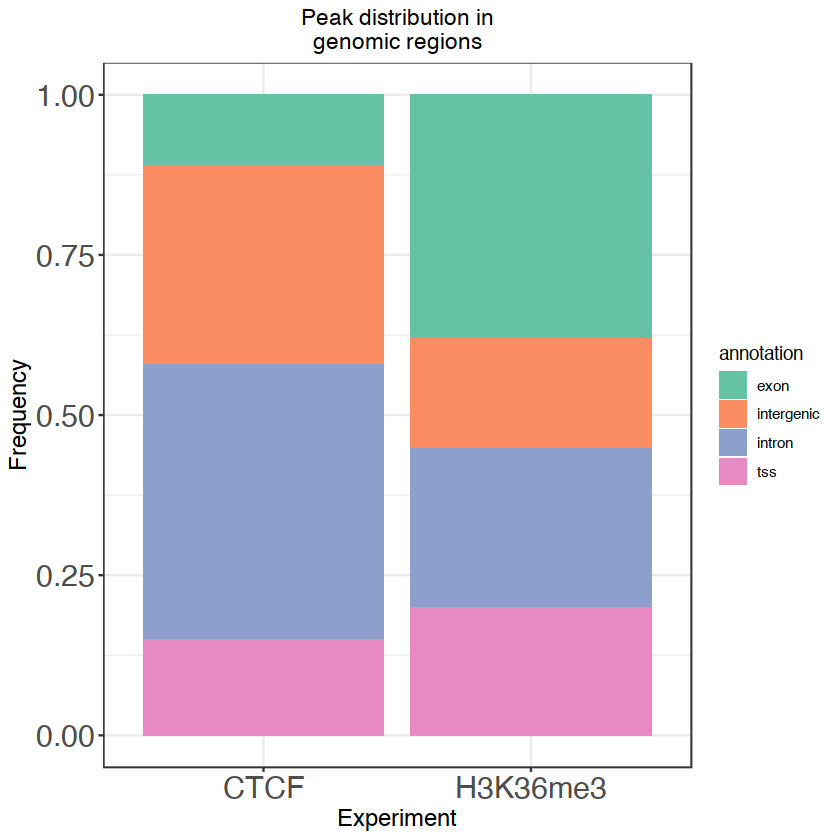

In [37]:
# ピークの分布を可視化
ggplot(data = annot_peaks_df, 
       aes(
           x    = experiment, 
           y    = frequency, 
           fill = annotation
        )) +
  geom_bar(stat='identity') +
  scale_fill_brewer(palette='Set2') +
  theme_bw()+
  theme(
    axis.text = element_text(size=18, face='bold'),
    axis.title = element_text(size=14,face="bold"),
    plot.title = element_text(hjust = 0.5))  +
  ggtitle('Peak distribution in\ngenomic regions') +
  xlab('Experiment') +
  ylab('Frequency')